In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import itertools
import numpy.matlib
import re

% matplotlib inline

## HH model

$\begin{aligned} C \frac { d V } { d t } & = - \overline { g } _ { L } \left( V - V _ { L } \right) - \overline { g } _ { \mathrm { Na } } m ^ { 3 } h \left( V - V _ { \mathrm { Na } } \right) - \overline { g } _ { \mathrm { K } } n ^ { 4 } \left( V - V _ { \mathrm { K } } \right) + I ( t ) \\ \frac { d n } { d t } & = \frac { 0.01 ( - V + 10 ) } { e ^ { ( - V + 10 ) / 10 } - 1 } ( 1 - n ) - 0.125 e ^ { - V / 80 } n \\ \frac { d m } { d t } & = \frac { 0.1 ( - V + 25 ) } { e ^ { ( - V + 25 ) / 10 } - 1 } ( 1 - m ) - 4 e ^ { - V / 18 } m \\ \frac { d h } { d t } & = 0.07 e ^ { - V / 20 } ( 1 - h ) - \frac { 1 } { e ^ { ( - V + 30 / 10 } + 1 } h \end{aligned}$

In [2]:
#parameters
gN = 120 #mmho/cm2
gK = 36 #mmho/cm2
gL = 0.3 #mmho/cm2
VN = 115 #mV
VK = -12 #mV
VL = 10.613 #mV
C = 1 #μF/cm2

In [3]:
#initials
dt = 0.01
t = np.arange(0,50,dt)
I = np.zeros(len(t))#+20 #20
V = np.zeros(len(t))
V[0] = -65 #initialize near resting potential (this could be determined by running it with random inital conditions)
n = np.zeros(len(t))
m = np.zeros(len(t))
h = np.zeros(len(t))

In [8]:
#iteration for dynamics
for i in range(1,len(t)):
    V[i] = V[i-1] + dt*(I[i] - gN*m[i-1]**3*h[i-1]*(V[i-1]-VN) - gK*n[i-1]**4*(V[i-1]-VK) - gL*(V[i-1]-VL))/C
    
    n[i] = n[i-1] + dt*((1-n[i-1])*(0.01*(-V[i-1]+10)/(np.exp((-V[i-1]+10)/10)-1)) - n[i-1]*(0.125*np.exp(-(V[i-1])/80)))
    
    m[i] = m[i-1] + dt*((1-m[i-1])*(0.1*(-V[i-1]+25)/(np.exp((-V[i-1]+25)/10)-1)) - m[i-1]*(4*np.exp(-(V[i-1])/18)))
    
    h[i] = h[i-1] + dt*((1-h[i-1])*(0.07*np.exp(-(V[i-1])/20)) - h[i-1]*(1/(np.exp((-V[i-1]+30)/10)+1)))
    

0.0036435764467397944


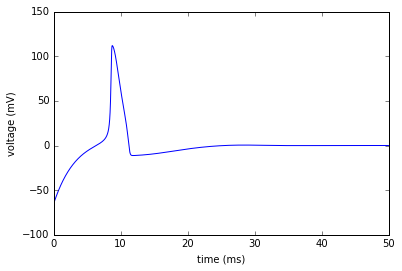

In [9]:
#plot traces of an action potential
plt.plot(t,V)
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)') 
print(V[-1])  #equilibrium/resting membran potential

In [11]:
def HH(I):
    for i in range(1,len(t)):
        V[i] = V[i-1] + dt*(I[i] - gN*m[i-1]**3*h[i-1]*(V[i-1]-VN) - gK*n[i-1]**4*(V[i-1]-VK) - gL*(V[i-1]-VL))/C

        n[i] = n[i-1] + dt*((1-n[i-1])*(0.01*(-V[i-1]+10)/(np.exp((-V[i-1]+10)/10)-1)) - n[i-1]*(0.125*np.exp(-(V[i-1])/80)))

        m[i] = m[i-1] + dt*((1-m[i-1])*(0.1*(-V[i-1]+25)/(np.exp((-V[i-1]+25)/10)-1)) - m[i-1]*(4*np.exp(-(V[i-1])/18)))

        h[i] = h[i-1] + dt*((1-h[i-1])*(0.07*np.exp(-(V[i-1])/20)) - h[i-1]*(1/(np.exp((-V[i-1]+30)/10)+1)))
        
    return V
    

In [12]:
from scipy.ndimage import measurements

def peak_finder(x0, thresh):
    '''
    A peak finding algorithm that considers neares possible points crossing a threshold.
    '''
    assert x0.ndim == 1
    clusters, ix = measurements.label(x0 > thresh)
    if ix==0:
        peak_loc = []
        peak_mag = []
    else:
        peak_loc = np.concatenate(measurements.maximum_position(x0, labels=clusters, index=np.arange(ix)+1))
        peak_mag = measurements.maximum(x0, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag

In [15]:
###find threshold and spike frequency
thr = 50
Is = np.logspace(0,np.log(60)/np.log(10),20) #different input current from 0 to 60 μA/cm2, sample in log space
spks = np.zeros(len(Is))
for i in range(0,len(Is)):
    II = Is[i]+np.zeros(len(t))
    vv = HH(II)
    peak_loc, peak_mag = peak_finder(vv, thr) #detect peaks
    if len(peak_loc)==1:
        spks[i] = 0
    else:
        spks[i] = len(peak_loc)

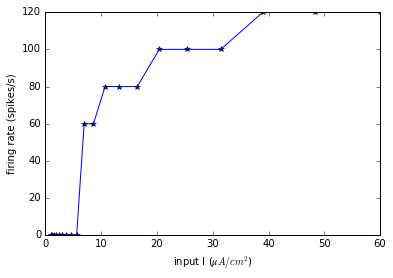

In [17]:
#plot nonlinear spike rate function
plt.plot(Is,spks/(50/1000),'-*') #convert spike counts in 50ms to firing rate
plt.ylabel('firing rate (spikes/s)')
plt.xlabel('input I ($μA/cm^2$)') 

In [91]:
#impedance of HH model under periodic drive
const = 4
ws = np.arange(0,0.3,0.02)  #frequency/1000
spks = np.zeros(len(ws))
for wi,ww in enumerate(ws):
    z = np.sin(ww*(np.pi*2)*t)
    II = const + z
    vv = HH(II)
    peak_loc, peak_mag = peak_finder(vv, thr) #detect peaks
    if len(peak_loc)==1:
        spks[wi] = 0
    else:
        spks[wi] = len(peak_loc)

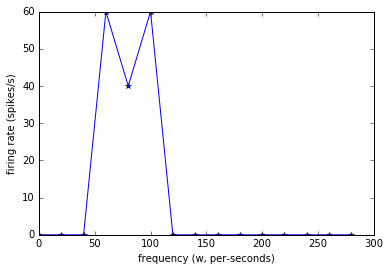

In [92]:
#plot frequnecy tuning
plt.plot(ws*1000,spks/(50/1000),'-*') #convert spike counts in 50ms to firing rate
plt.ylabel('firing rate (spikes/s)')
plt.xlabel('frequency (w, per-seconds)') 

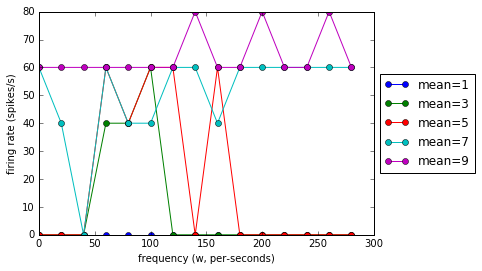

In [98]:
#changing mean
ms = np.arange(1,10,2)
for mm in ms:
    const = mm
    ws = np.arange(0,0.3,0.02)  #frequency/1000
    spks = np.zeros(len(ws))
    for wi,ww in enumerate(ws):
        z = np.sin(ww*(np.pi*2)*t)
        II = const + z
        vv = HH(II)
        peak_loc, peak_mag = peak_finder(vv, thr) #detect peaks
        if len(peak_loc)==1:
            spks[wi] = 0
        else:
            spks[wi] = len(peak_loc)
    plt.plot(ws*1000,spks/(50/1000),'-o',label='mean=%s'%mm) #convert spike counts in 50ms to firing rate

plt.ylabel('firing rate (spikes/s)')
plt.xlabel('frequency (w, per-seconds)') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Real axon

$I = \frac { a } { 2 R } \frac { \partial ^ { 2 } V } { \partial z ^ { 2 } }$